# XGBoost

In this notebook you will use GPU-accelerated gradient boosting to predict the probability that a given individual is infected with the simulated virus.

## Objectives

By the time you complete this notebook you will be able to:

- Use GPU-accelerated XGBoost

## Imports

We will be using the [XGBoost](https://xgboost.readthedocs.io/en/latest/) library to create the gradient boosted model for this exercise.

In addition to the usual RAPIDS components, we import several libraries that will help us understand and evaluate the XGBoost model once we have trained it. 

In [1]:
import cudf
import cuml
import cupy as cp

from cuml.model_selection import train_test_split

# visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import graphviz

# model analysis
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import xgboost as xgb

# xgboost version 1.0 or later is required to directly convert from cudf Dataframes to xgboost DMatrix format
print('XGBoost version: ', xgb.__version__)

XGBoost version:  1.5.2


## Load Data

For this notebook we load a subset of the population data, including both the columns we used before for logistic regression and the coordinate columns. XGBoost allows us to use data that have nonlinear relationships with the outcome of interest, and geospatial data often fall into that category.

In [2]:
gdf = cudf.read_csv('./data/pop_2-08.csv', usecols=['age', 'sex', 'northing', 'easting', 'infected'])

In [3]:
gdf.dtypes

age         float64
sex         float64
northing    float64
easting     float64
infected    float64
dtype: object

In [4]:
gdf.shape

(58479894, 5)

In [5]:
gdf.head()

,age,sex,northing,easting,infected
0,0.0,0.0,515491.5313,430772.1875,0.0
1,0.0,0.0,503572.4688,434685.8750,0.0
2,0.0,0.0,517903.6563,432565.5313,0.0
3,0.0,0.0,517059.9063,427660.6250,0.0
4,0.0,0.0,509228.6875,425527.7813,0.0


Before splitting the data for training and testing, we check our memory status. We want to be below half the memory usage on the active GPU so that the temporary increase from the split still fits in memory.

In [6]:
!nvidia-smi

Tue Nov 14 13:27:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1B.0 Off |                    0 |
| N/A   28C    P0    25W /  70W |   3176MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:1C.0 Off |                    0 |
| N/A   

## Train-Test Split

We again use the splitting method to create training and testing data subsets, keeping in mind that we will be using additional memory by doing so.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(gdf[['age', 'sex', 'northing', 'easting']], gdf['infected'])

In [8]:
!nvidia-smi

Tue Nov 14 13:32:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1B.0 Off |                    0 |
| N/A   29C    P0    31W /  70W |   6764MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:1C.0 Off |                    0 |
| N/A   

Now that we have training and testing subsets, we can delete the original data so we have room for the algorithm's memory overhead--not critical in this case, but a useful practice when trying to train on as much data as possible.

In [9]:
del(gdf)

## Setting XGBoost parameters

We can now set the parameters for this XGBoost training run. These will determine the type and size of trees being created, as well as the way we measure success. 

The `gpu_hist` tree method is a critical parameter: it tells XGBoost that we want the training to run on GPU.

For our use case, we again want to predict the probability that an individual is infected with the virus, so we set the `binary:logistic` objective (binary outcome, using the logistic method to get probabilities).

Other parameter options and meanings can be found at [XGBoost parameters](https://xgboost.readthedocs.io/en/latest/parameter.html).

In [10]:
params = {
    'max_depth':    8,
    'max_leaves':   2**8,
    'tree_method':  'gpu_hist',
    'objective':    'binary:logistic',
    'grow_policy':  'lossguide',
    'eval_metric':  'logloss',
    'subsample':    '0.8'
}

## Training the Model

XGBoost uses a special, highly efficient data structure called a `DMatrix`, so we pass the training dataframes into it to create one.

Note that the data is remaining on GPU, passing directly from cuDF to XGBoost.

In [11]:
dtrain = xgb.DMatrix(x_train, y_train)

Now we are ready to train the model.

In [12]:
%time model = xgb.train(params, dtrain, num_boost_round=100)

CPU times: user 18.5 s, sys: 162 ms, total: 18.6 s
Wall time: 18.8 s


As a point of comparison, code to run the CPU-only version of XGBoost is provided at the bottom of this exercise.

## Inspecting the Model

We can examine the model in several ways. First, we can see which features the model believes to be most important in its assessment. Higher F scores indicate higher estimated importance.

There appears to be a strong geospatial component to the infection distribution, since the easting and northing features have the highest F scores. In addition, age appears to have a stronger impact than sex in determining infection rates (consistent with the results we received from the logistic regression analysis).

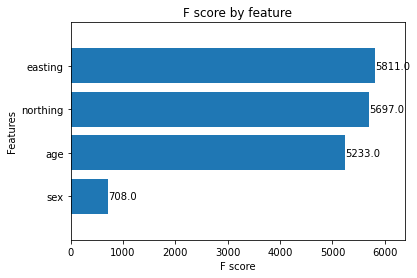

In [13]:
ax = xgb.plot_importance(model, height=.8)
ax.grid(False)
ax.set_title('F score by feature')
plt.show()

We can also pull out individual trees within the model and see exactly which decisions it uses for its contributions to the ensemble. Notice that as with all ensemble methods, individual trees may not appear to produce major differences in outcomes (values on the leaf nodes); the aggregation of often individually-weak trees into a strong model gives XGBoost its power.

Try changing `num_trees` to examine different trees in the model. Changing `rankdir` to `'TB'` will reorient the trees to top-down.

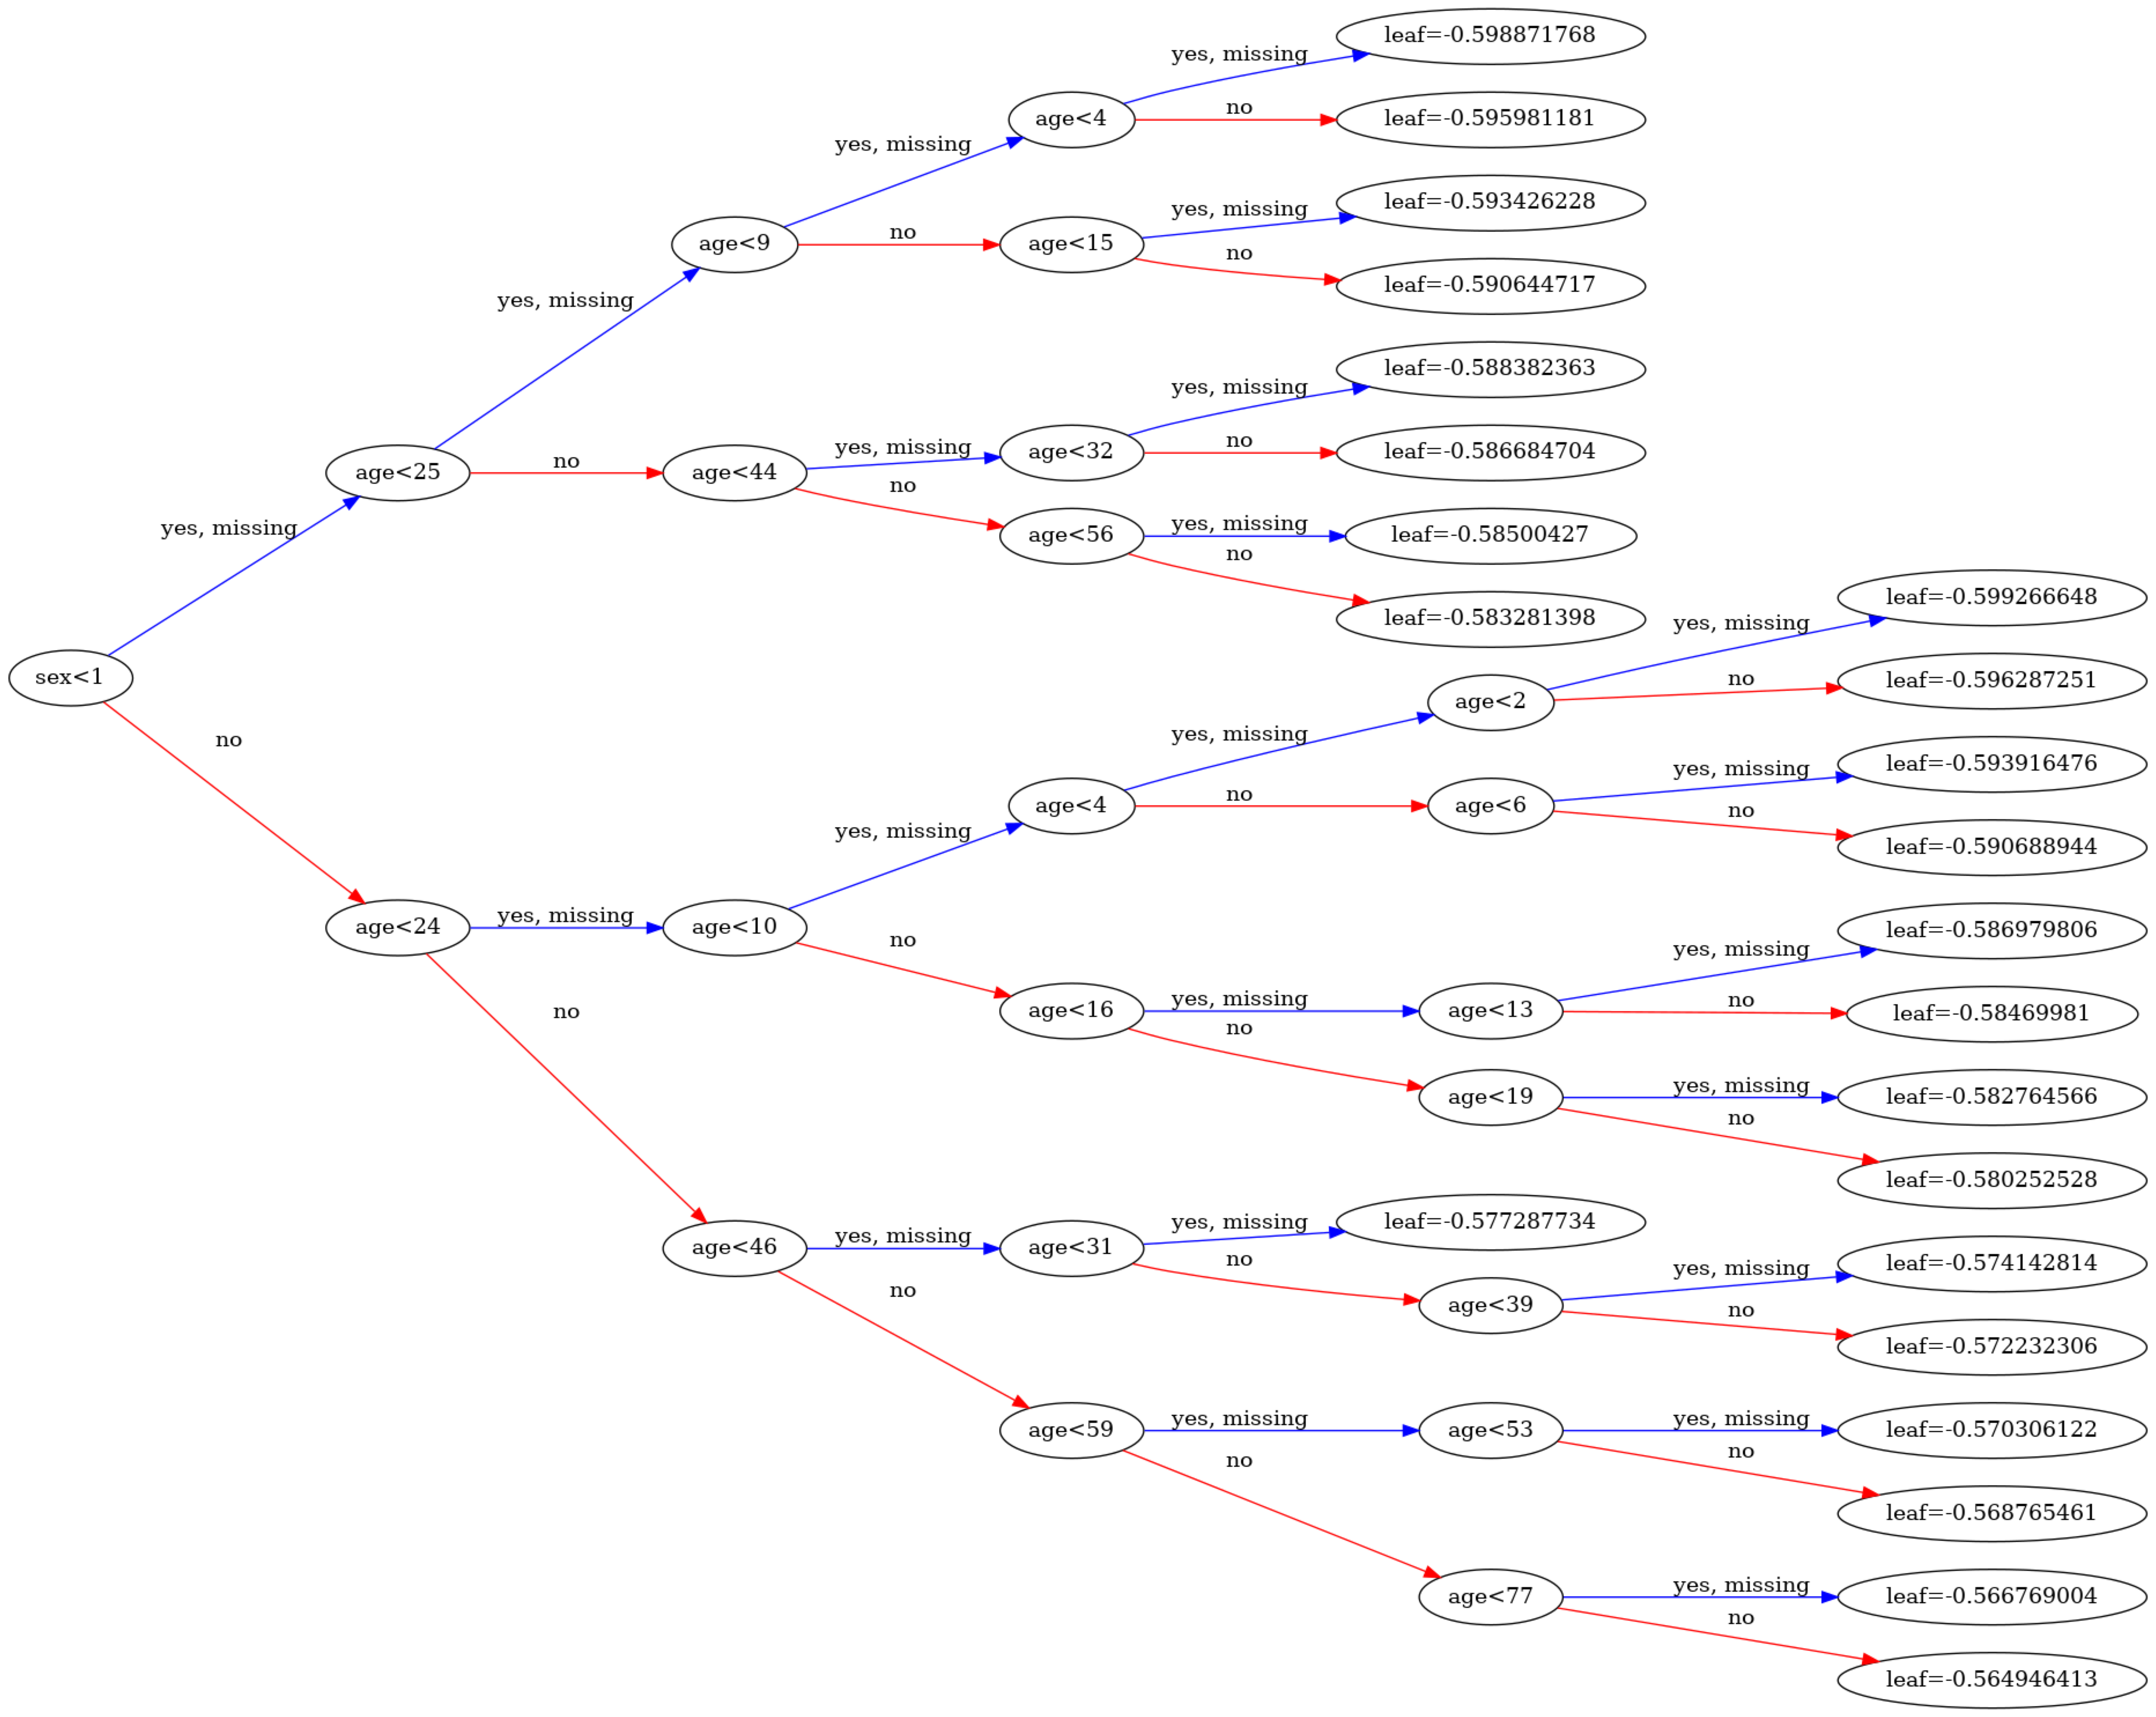

In [14]:
xgb.plot_tree(model, num_trees=0, rankdir='LR')

# get current figure to set the size
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(100, 100)

## Making Predictions

Once we are comfortable with the model, we move to making predictions with it. We confirm that we will be making predictions on over 11 million rows of data.

In [15]:
x_test.shape

(14619974, 4)

We convert the *X* matrix to a `DMatrix` as before, then make a prediction for each row. Notice the amount of time it takes to make over 11 million predictions.

In [17]:
dtest = xgb.DMatrix(x_test)
%time y_pred = model.predict(dtest)

CPU times: user 432 ms, sys: 23.7 ms, total: 456 ms
Wall time: 456 ms


Now we would like to see how good those predictions were. One common evaluation method is to calculate the area under the curve (AUC) of the receiver operating characteristic (ROC) curve.

The predictions are a `numpy` array, so we convert the test labels to match, then run the ROC curve calculation.

In [18]:
y_test_cpu = cp.asnumpy(cp.array(y_test))
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test_cpu, y_pred)

Last, we can plot the curve and calculate the AUC score to help us assess the trade offs between true and false positive rates.

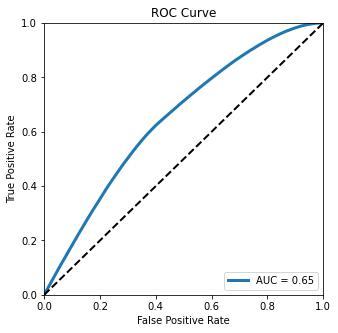

In [19]:
auc_result = auc(false_pos_rate, true_pos_rate)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(false_pos_rate, true_pos_rate, lw=3,
        label='AUC = {:.2f}'.format(auc_result))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc='lower right');
plt.show()

### (Optional) Comparison: CPU-only XGBoost

Below we provide code for training and inferring from a CPU-only XGBoost using the same model parameters other than switching the histogram tree method from GPU to CPU.

In [ ]:
params['tree_method'] = 'hist'
dtrain_cpu = xgb.DMatrix(x_train.to_pandas(), y_train.to_pandas())
%time model_cpu = xgb.train(params, dtrain_cpu, num_boost_round=100)

In [ ]:
dtest_cpu = xgb.DMatrix(x_test.to_pandas())
%time y_pred_cpu = model_cpu.predict(dtest_cpu)

## Aside: NVIDIA Triton Inference Server

While it is beyond the scope of this course, we would like to call attention to a powerful tool for performing inference, [Triton Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server).

Triton can perform blazing-fast inference at massive scale using models just like what you have created in this notebook and has incredibly wide adoption across several industries.

Please consider taking the time to learn more about Triton using the following resources:

- [Triton Inference Server Home Page](https://developer.nvidia.com/nvidia-triton-inference-server): The starting point for learning Triton, this page includes links to docs, case studies, and technical presentations.
- [Deploying a Model for Inference at Production Scale](https://courses.nvidia.com/courses/course-v1:DLI+S-FX-03+V1/about): This interactive self-paced DLI course is the best way to start learning Triton.
- [NVIDIA Developer Blog](https://developer.nvidia.com/blog/tag/triton/): The NVIDIA Developer Blog has a wealth of resources to help you get started with Triton.
- [Download Triton on NGC](https://ngc.nvidia.com/catalog/containers/nvidia:tritonserver?ncid=progr-554576).

<br>
<div align="center"><h2>Please Restart the Kernel</h2></div>

In [20]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Next

In the next notebook, you will use GPU-accelerated graph analytics with cuGraph to identify the single shortest path to hospitals both by distance and by time. You will also visualize the results of your findings.